## **Spotify Top 50 음악 트랙에 대한 YouTube 댓글을 분석하여, 긍정적인 댓글 확률과 트랙의 인기도 간의 상관관계를 파악**

1. **Spotify Top 50 음악 트랙 선정**
2. **YouTube API를 통해 댓글 수집**
3. **수집된 댓글 전처리**
   - 이모티콘 변환
   - 다양한 언어를 영어로 번역
4. **긍정적인 댓글 확률 계산**
5. **인기와 긍정적인 댓글 확률 간 상관관계 분석**

사용 라이브러리 추가



In [ ]:
# 필요한 라이브러리 임포트
import requests
import urllib.parse
import pandas as pd
from googletrans import Translator
import googleapiclient.discovery

# YouTube API 키
youtube_api_key = ''


Top 50곡들에 대한 정보는 미리 저장해 두었던 global_analysis.csv에서 가져옵니다.



In [5]:
df = pd.read_csv('/content/top50_anal.csv')
df.head()

,track_name,artist_name,track_id,popularity,genres,danceability,energy,valence,tempo,acousticness,instrumentalness,liveness,loudness,speechiness,key,mode,time_signature
0,APT.,ROSÉ,2vDkR3ctidSd17d2CygVzS,65,k-pop,0.778,0.786,0.942,149.030,0.0286,0.0,0.3470,-4.473,0.2590,0,0,4
1,Die With A Smile,Lady Gaga,2plbrEY59IikOBgBGLjaoe,100,"art pop, dance pop, pop",0.521,0.592,0.535,157.969,0.3080,0.0,0.1220,-7.777,0.0304,6,0,3
2,squabble up,Kendrick Lamar,0nj9Bq5sHDiTxSHunhgkFb,75,"conscious hip hop, hip hop, rap, west coast rap",0.874,0.672,0.711,103.921,0.0206,0.0,0.0783,-5.568,0.1980,0,1,4
3,luther (with sza),Kendrick Lamar,2CGNAOSuO1MEFCbBRgUzjd,32,"conscious hip hop, hip hop, rap, west coast rap",0.707,0.575,0.576,138.008,0.2510,0.0,0.2480,-7.546,0.1250,2,1,4
4,wacced out murals,Kendrick Lamar,5gOfC9UzZQzTyShqPMrpjT,75,"conscious hip hop, hip hop, rap, west coast rap",0.761,0.501,0.502,81.998,0.2490,0.0,0.1360,-10.759,0.4590,9,0,4


# **데이터 수집**

## **YouTube API를 사용해 곡명과 아티스트로 YouTube 영상을 검색하고, 각 영상들의 댓글을 100개씩 수집**






**데이터 수집 과정:**

1. **YouTube URL 수집**: 먼저, 각 트랙에 해당하는 **YouTube URL**을 수집합니다.

2. **YouTube ID 파싱**: 수집된 URL에서 **YouTube의 고유 ID**를 파싱합니다.

3. **YouTube API 호출**: 영상 ID를 기반으로 YouTube API를 호출하여 해당 영상의 댓글을 수집합니다.

댓글을 가져올 수 있는 API는 video id를 통해서만 접근이 가능하기 때문에,  
먼저 youtube url을 받아온 후 파싱을 통해 video id를 추출합니다.





**1. 각 곡들에 대한 유튜브 URL 요청**

In [ ]:
# 결과를 저장할 리스트 초기화
results = []

# 각 트랙에 대해 YouTube URL 생성
for index, row in df.iterrows():
    track_name = row['track_name']
    artist_name = row['artist_name']

    # 검색할 쿼리 생성
    query = f"{track_name} {artist_name}"

    # YouTube API URL 구성
    youtube_url = f"https://www.googleapis.com/youtube/v3/search?part=snippet&q={urllib.parse.quote(query)}&key={youtube_api_key}"

    # YouTube 데이터 요청
    response = requests.get(youtube_url)

    if response.status_code == 200:
        data = response.json()
        if 'items' in data:
            video_id = data['items'][0]['id']['videoId']
            results.append([track_name, artist_name, f"https://www.youtube.com/watch?v={video_id}"])
        else:
            results.append([track_name, artist_name, 'No video found'])
    else:
        results.append([track_name, artist_name, f"Error: {response.status_code}"])


결과를 DataFrame으로 변환

In [ ]:
top50_youtube_url = pd.DataFrame(results, columns=['track_name', 'artist_name', 'youtube_url'])

top50_youtube_url.head()

,track_name,artist_name,youtube_url
0,APT.,ROSÉ,https://www.youtube.com/watch?v=ekr2nIex040
1,Die With A Smile,Lady Gaga,https://www.youtube.com/watch?v=kPa7bsKwL-c
2,squabble up,Kendrick Lamar,https://www.youtube.com/watch?v=fuV4yQWdn_4
3,luther (with sza),Kendrick Lamar,https://www.youtube.com/watch?v=geWd7FkjLLA
4,wacced out murals,Kendrick Lamar,https://www.youtube.com/watch?v=YwUQ_5iV9pY


**2.유튜브 비디오 ID로 댓글 가져오기**

Youtube URL을 통해 댓글을 받기 위한 초기 설정





In [ ]:
# YouTube API 설정
youtube = googleapiclient.discovery.build("youtube", "v3", developerKey=youtube_api_key)

각 곡당 100개의 댓글을 가져옵니다.

In [ ]:
def get_video_comments(video_id):
    comments = []

    try:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            textFormat="plainText",
            maxResults=100  # 한 번에 가져올 댓글 수
        )
        response = request.execute()

        # 댓글 추출
        for item in response['items']:
            comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
            comments.append({
                'comment': comment
            })

    except googleapiclient.errors.HttpError as e:
        error_content = e.content.decode("utf-8")
        if "commentsDisabled" in error_content:
            print(f"Comments are disabled for video ID: {video_id}")
        else:
            print(f"An error occurred: {e}")

    return comments


유튜브 URL이 https://www.youtube.com/watch?v=ekr2nIex040 과 같은 형식을 가진다면,  
`v=` 뒤에 있는 부분인 `ekr2nIex040`이 **Video ID**이므로 이를 파싱하여 활용합니다.

In [ ]:
# video_urls.csv에서 유튜브 URL 불러오기
# 비디오 ID를 통해 댓글 가져오기
all_comments = []

for index, row in top50_youtube_url.iterrows():
    video_url = row['youtube_url']       # youtube_url 컬럼을 사용
    track_name = row['track_name']       # track_name 컬럼을 사용
    video_id = video_url.split('v=')[1]  # URL에서 비디오 ID 추출 (v= 뒤의 ID)

    # 댓글 가져오기
    print(f"Getting comments for: {track_name}")
    comments = get_video_comments(video_id)

    # 댓글에 곡 제목 추가
    for comment in comments:
        comment['track_name'] = track_name

    all_comments.extend(comments)

# 댓글을 데이터프레임으로 변환
top50_with_comment = pd.DataFrame(all_comments)
top50_with_comment = top50_with_comment[['track_name', 'comment']]  # track_name을 첫 번째로 배치


Getting comments for: APT.
Getting comments for: Die With A Smile
Getting comments for: squabble up
Getting comments for: luther (with sza)
Getting comments for: wacced out murals


Getting comments for: tv off (feat. lefty gunplay)
Comments are disabled for video ID: 2l5utgkg4Rs
Getting comments for: BIRDS OF A FEATHER
Getting comments for: hey now (feat. dody6)


Comments are disabled for video ID: TxPBDXzj7ZQ
Getting comments for: man at the garden
Getting comments for: reincarnated
Getting comments for: That’s So True
Getting comments for: Who


Getting comments for: dodger blue (feat. wallie the sensei, roddy ricch, siete7x)
Comments are disabled for video ID: CHX3G7BjHyI
Getting comments for: heart pt. 6
Getting comments for: peekaboo (feat. azchike)
Comments are disabled for video ID: CqKhf71AdxI
Getting comments for: All I Want for Christmas Is You
Getting comments for: Running Wild
Getting comments for: Tu Boda
Getting comments for: Sailor Song
Getting comments for: Last Christmas - Single Version
Getting comments for: Espresso
Getting comments for: gnx (feat. hitta j3, youngthreat, peysoh)
Getting comments for: gloria (feat. sza)
Getting comments for: Taste
Getting comments for: WILDFLOWER
Getting comments for: Qué Pasaría...
Getting comments for: Si Antes Te Hubiera Conocido
Getting comments for: Timeless (with Playboi Carti)
Getting comments for: Good Luck, Babe!
Getting comments for: Beautiful Things
Getting comments for: Rockin' Around The Christmas Tree
Getting comments for: Khé?
Getting comments for: Please Please 

Getting comments for: I Love You, I'm Sorry
Getting comments for: I Wanna Be Yours
Comments are disabled for video ID: nyuo9-OjNNg
Getting comments for: number one girl
Getting comments for: Locked out of Heaven


Getting comments for: The Emptiness Machine
Getting comments for: Sticky (feat. GloRilla, Sexyy Red & Lil Wayne)
Comments are disabled for video ID: 16KSivdIGjQ
Getting comments for: Snowman
Getting comments for: A Bar Song (Tipsy)
Getting comments for: Let It Snow! Let It Snow! Let It Snow!
Getting comments for: Yellow


데이터 확인

In [ ]:
# track_name당 첫 번째 댓글만 선택
unique_comments = top50_with_comment.groupby('track_name').first().reset_index()

# 결과 확인
print(unique_comments[['track_name', 'comment']].head())

                        track_name  \
0               A Bar Song (Tipsy)   
1                             APT.   
2  All I Want for Christmas Is You   
3               BIRDS OF A FEATHER   
4                 Beautiful Things   

                                             comment  
0                                              ❤❤❤❤❤  
1                                             442.5m  
2  Just listening to the song brings Christmas ch...  
3                                                  ❤  
4                               So what do we think?  


# **전처리**

**댓글 전처리 과정:**

1. **이모티콘 변환**: 댓글에 포함된 이모티콘은 감정 분석에 방해가 될 수 있기 때문에 이를 **텍스트**로 변환합니다. 이를 통해 이모티콘이 전달하는 감정을 명확하게 파악할 수 있습니다.

2. **언어 번역**: 댓글들은 다양한 언어로 작성되어 있을 수 있습니다. 이 댓글들을 **영어로 변환**하여 분석을 진행하기 위해 번역 api를 사용합니다. 영어로 변환된 댓글은 이후 감정 분석에 활용됩니다.

##### 수집한 댓글 데이터를 확인한 결과, 이모티콘이 포함되어 있어 감정 분석에 어려움이 예상됩니다. 이를 해결하기 위해 **emoji_translate** 라이브러리의 `Translator` 클래스를 활용하여 이모티콘을 텍스트로 변환하였습니다.

In [ ]:
# Google Translate 객체 생성
translator = Translator()

##### `emoji.demojize` 함수를 사용하여 이미지를 영어로 변환한 결과입니다.  
##### 예를 들어, 이모지 "😀"는 ":grinning_face:"와 같은 텍스트로 변환됩니다.

In [ ]:
from emoji_translate.emoji_translate import Translator as EmojiTranslator
import pandas as pd

# 이모지 변환 초기화
emo = EmojiTranslator(exact_match_only=False, randomize=True)


# 이모지 변환 함수
def convert_emojis(comment):
    try:
        # 이모지를 텍스트로 변환
        demojified_comment = emo.demojify(comment)
        return demojified_comment
    except Exception as e:
        print(f"Error processing comment: {comment} - {e}")
        return comment  # 실패 시 원본 댓글 반환

# 이모지 변환 수행
top50_with_comment['demojified_comment'] = top50_with_comment['comment'].apply(convert_emojis)


# 데이터 확인
top50_with_comment.head(10)


,track_name,comment,demojified_comment
0,APT.,442.5m,442.5m
1,APT.,Only problem i have with this song is that its...,Only problem i have with this song is that its...
2,APT.,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST
3,APT.,Anyong ngaseou,Anyong ngaseou
4,APT.,esta no es my rose,esta no es my rose
5,APT.,😂😂😂,joyjoyjoy
6,APT.,First... What song? \nNow addicted why.... Its...,First... What song? \nNow addicted why.... Its...
7,APT.,❤ rose,red heart rose
8,APT.,APT.,APT.
9,APT.,1:03 I thought they were twerking and got me l...,1:03 I thought they were twerking and got me l...


번역에 문제가 생길 수 있는 URL을 제거하고,  
너무 긴 문자열도 40자로 길이제한합니다.

In [ ]:
import re

# URL을 제거하는 함수
def remove_url(comment):
    return re.sub(r'http\S+', '', comment)  # http로 시작하는 URL 제거

# 길이를 40자 이하로 제한하는 함수
def limit_comment_length(comment, max_length=40):
    return comment[:max_length]  # 최대 길이 제한

# 댓글 전처리 함수
def preprocess_comment(comment):
    try:
        # URL 제거
        clean_comment = remove_url(comment)

        # 길이 제한
        clean_comment = limit_comment_length(clean_comment)

        return clean_comment
    except Exception as e:
        print(f"Error preprocessing comment: {comment} - {e}")
        return comment  # 실패 시 원본 댓글 반환


##### 모든 댓글이 영어로 작성되지 않았기 때문에, 댓글을 영어로 번역하여 분석에 사용합니다.






In [ ]:
top50_with_comment['clean_comment'] = top50_with_comment['demojified_comment'].apply(preprocess_comment)
top50_with_comment.head(10)

,track_name,comment,demojified_comment,clean_comment
0,APT.,442.5m,442.5m,442.5m
1,APT.,Only problem i have with this song is that its...,Only problem i have with this song is that its...,Only problem i have with this song is th
2,APT.,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST
3,APT.,Anyong ngaseou,Anyong ngaseou,Anyong ngaseou
4,APT.,esta no es my rose,esta no es my rose,esta no es my rose
5,APT.,😂😂😂,joyjoyjoy,joyjoyjoy
6,APT.,First... What song? \nNow addicted why.... Its...,First... What song? \nNow addicted why.... Its...,First... What song? \nNow addicted why...
7,APT.,❤ rose,red heart rose,red heart rose
8,APT.,APT.,APT.,APT.
9,APT.,1:03 I thought they were twerking and got me l...,1:03 I thought they were twerking and got me l...,1:03 I thought they were twerking and go


모든 댓글 영어로 번역

In [ ]:
from deep_translator import GoogleTranslator as DeepGoogleTranslator

# 번역 함수
def translate_comment(comment):
    if not comment:  # 빈 문자열 처리
        print(f"Skipping empty comment.")  # 빈 댓글 처리
        return "No comment"  # 빈 댓글일 경우 기본 메시지 반환
    try:
        # 번역 수행
        translated_comment = DeepGoogleTranslator(source='auto', target='en').translate(comment)
        #print(f"Successfully translated comment: {comment[:30]}...")  # 번역 성공 시 출력 (첫 30자만 표시)
        return translated_comment
    except Exception as e:
        print(f"Error translating comment: {comment[:30]}... - {e}")  # 오류 발생 시 출력 (첫 30자만 표시)
        return "Translation error"  # 실패 시 오류 메시지 반환


In [ ]:
top50_with_comment['translated_comment'] = top50_with_comment['clean_comment'].apply(translate_comment)


Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.
Skipping empty comment.


모든 댓글이 영어로 번역됨을 확인하실 수 있습니다.

In [ ]:
top50_with_comment.head(10)

,track_name,comment,demojified_comment,clean_comment,translated_comment
0,APT.,442.5m,442.5m,442.5m,442.5m
1,APT.,Only problem i have with this song is that its...,Only problem i have with this song is that its...,Only problem i have with this song is th,Only problem i have with this song is th
2,APT.,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST,OMG ROSE YU ARE THE BEST
3,APT.,Anyong ngaseou,Anyong ngaseou,Anyong ngaseou,Form of ngaseou
4,APT.,esta no es my rose,esta no es my rose,esta no es my rose,This is not my rose
5,APT.,😂😂😂,joyjoyjoy,joyjoyjoy,joyjoyjoy
6,APT.,First... What song? \nNow addicted why.... Its...,First... What song? \nNow addicted why.... Its...,First... What song? \nNow addicted why...,First... What song? \nNow addicted why...
7,APT.,❤ rose,red heart rose,red heart rose,red heart rose
8,APT.,APT.,APT.,APT.,APT.
9,APT.,1:03 I thought they were twerking and got me l...,1:03 I thought they were twerking and got me l...,1:03 I thought they were twerking and go,1:03 I thought they were twerking and go


# **감정분석**

**감정 분석 과정:**

1. **감정 분석 모델 사용**: 변환된 영어 댓글들을 대상으로 **감정 분석**을 수행합니다. 이 과정에서는 댓글의 **긍정적** 또는 **부정적** 감정을 평가하여 각 댓글의 감정 상태를 추출합니다.

2. **긍정도 및 부정도 확률 계산**: 감정 분석 모델을 통해 각 댓글의 **긍정 확률**과 **부정 확률**을 계산합니다. 이를 통해 각 댓글이 얼마나 긍정적이거나 부정적인지 수치적으로 확인할 수 있습니다.

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# VADER 감정 분석기 초기화
analyzer = SentimentIntensityAnalyzer()

감정 분석 함수 정의

In [ ]:
def get_sentiment_score(text):
    if isinstance(text, str):  # 문자열인 경우에만 분석
        sentiment = analyzer.polarity_scores(text)
        return sentiment['compound']  # 종합적인 감정 점수 반환
    return 0  # NaN 또는 비문자열인 경우 0 반환

'translated_comment' 컬럼에 대해 감정 분석 수행하고 'sentiment' 컬럼에 저장


In [ ]:
top50_with_comment['sentiment'] = top50_with_comment['translated_comment'].apply(get_sentiment_score)

감정 점수를 기준으로 긍정적, 부정적, 중립적 분류

In [ ]:
top50_with_comment['sentiment_label'] = top50_with_comment['sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

필요한 컬럼만 추출하여 새로운 데이터프레임 생성


In [ ]:
result = top50_with_comment[['track_name', 'translated_comment', 'sentiment', 'sentiment_label']]

# 결과를 새로운 CSV 파일로 저장
result.to_csv('video_comments_with_sentiment.csv', index=False, encoding='utf-8')

# 결과 확인
result.head()

,track_name,translated_comment,sentiment,sentiment_label
0,APT.,442.5m,0.0000,neutral
1,APT.,Only problem i have with this song is th,-0.4019,negative
2,APT.,OMG ROSE YU ARE THE BEST,0.6369,positive
3,APT.,Form of ngaseou,0.0000,neutral
4,APT.,This is not my rose,0.0000,neutral


In [ ]:
import pandas as pd

# CSV 파일에서 결과 로드
comments = pd.read_csv('/content/video_comments_with_sentiment.csv', encoding='utf-8')

곡 제목을 기준으로 groupby 한 후, sentiment_label에 대한 value_counts를 계산


In [ ]:
sentiment_counts_per_song = comments.groupby('track_name')['sentiment_label'].value_counts().unstack(fill_value=0)

# 결과 출력
print(sentiment_counts_per_song)

sentiment_label                            negative  neutral  positive
track_name                                                            
A Bar Song (Tipsy)                               13       31        55
APT.                                              5       63        32
All I Want for Christmas Is You                   7       61        32
BIRDS OF A FEATHER                               10       31        59
Beautiful Things                                  3       39        58
Die With A Smile                                  4       51        45
Espresso                                          8       54        38
Good Luck, Babe!                                 12       40        48
I Love You, I'm Sorry                             2       14        21
Jingle Bell Rock                                 10       59        31
Khé?                                              9       55        36
Last Christmas - Single Version                   1        6         5
Let It

In [ ]:
comments.head()

,track_name,translated_comment,sentiment,sentiment_label
0,APT.,442.5m,0.0000,neutral
1,APT.,Only problem i have with this song is th,-0.4019,negative
2,APT.,OMG ROSE YU ARE THE BEST,0.6369,positive
3,APT.,Form of ngaseou,0.0000,neutral
4,APT.,This is not my rose,0.0000,neutral


중립값을 제외하고, 긍정적반응의 수, 부정적 반응의 수만 이용하여 새로운 csv생성

In [2]:
import pandas as pd

# CSV 파일에서 결과 로드
comments = pd.read_csv('/content/video_comments_with_sentiment.csv', encoding='utf-8')

# 곡 제목을 기준으로 groupby 후, neutral을 제외하고 value_counts 계산
sentiment_counts = comments[comments['sentiment_label'] != 'neutral'] \
    .groupby('track_name')['sentiment_label'].value_counts().unstack(fill_value=0)

# 필요한 컬럼만 추출 (positive와 negative)
sentiment_counts_filtered = sentiment_counts[['positive', 'negative']]



In [3]:
sentiment_counts_filtered.head()

sentiment_label,positive,negative
track_name,,
A Bar Song (Tipsy),55,13
APT.,32,5
All I Want for Christmas Is You,32,7
BIRDS OF A FEATHER,59,10
Beautiful Things,58,3


In [6]:
merged_df = sentiment_counts_filtered.merge(df[['track_name', 'popularity']], on='track_name', how='left')

In [ ]:
merged_df.head()

,track_name,positive,negative,popularity
0,A Bar Song (Tipsy),55,13,84
1,APT.,32,5,65
2,All I Want for Christmas Is You,32,7,88
3,BIRDS OF A FEATHER,59,10,97
4,Beautiful Things,58,3,89


# **시각화**


**positive_probability=
(positive+negative) /
positive**  
수식을 활용하여 긍정적 확률을 구합니다.



In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 로드
data = merged_df

# 긍정 확률 계산
data['positive_probability'] = data['positive'] / (data['positive'] + data['negative'])

`popularity`가 60 미만인 데이터는 많지 않기 때문에  
`popularity`가 60 이상인 데이터만 필터링했습니다.

In [8]:
filtered_data = data[data['popularity'] > 60]

### **상관계수 계산**

In [9]:
correlation = filtered_data['popularity'].corr(filtered_data['positive_probability'])
print(correlation)

0.14612160628716214


### **그래프**

In [15]:
import matplotlib.font_manager as fm

# 한글 폰트 경로
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 경로 확인 후 정확한 경로 입력
font_prop = fm.FontProperties(fname=font_path)

# Matplotlib에서 사용할 폰트 설정
plt.rcParams['font.family'] = font_prop.get_name()

<ipython-input-23-2fa65bcd120b>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='popularity', y='positive_probability', data=filtered_data,


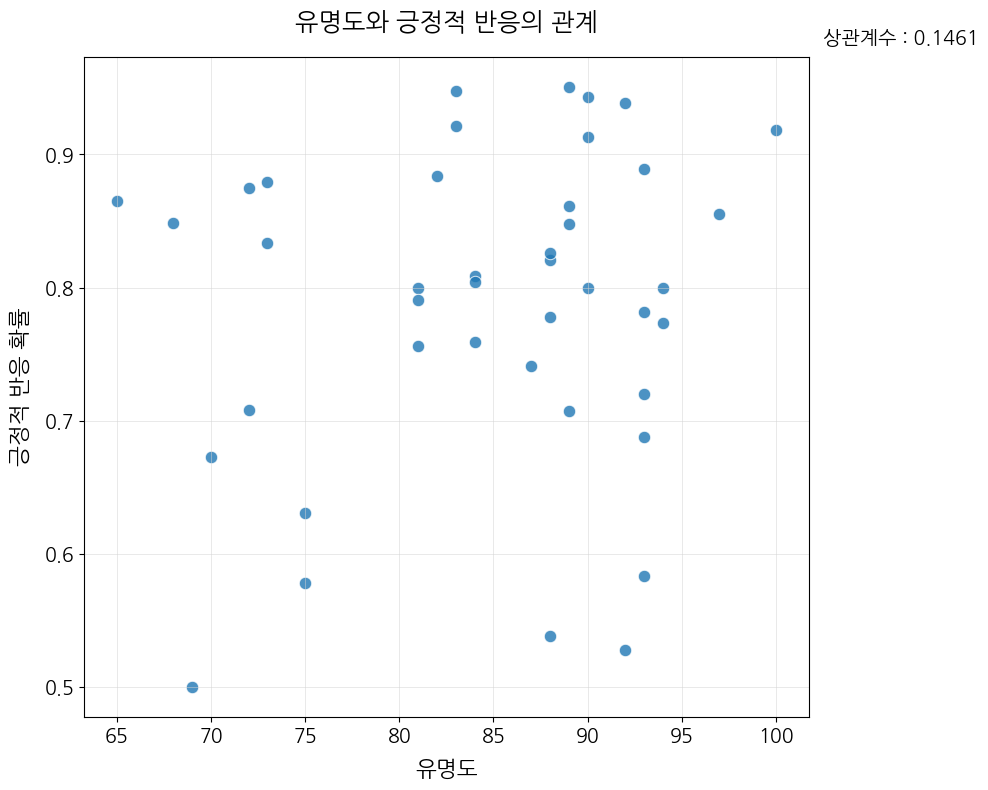

In [23]:
# 단독 산점도 그리기
plt.figure(figsize=(10, 8))  # 그래프 크기 설정
sns.scatterplot(x='popularity', y='positive_probability', data=filtered_data,
                alpha=0.8, s=80, edgecolor='w', palette='coolwarm')  # 점의 색상 팔레트 변경

# 그래프 제목 설정
plt.title('유명도와 긍정적 반응의 관계', fontsize=18, color='black', pad=20)

# 상관계수 텍스트
plt.text(x=1.02, y=1.02, s=f'상관계수 : {correlation:.4f}',
         fontsize=14, color='black', transform=plt.gca().transAxes, ha='left')  # 오른쪽 상단 배치

# x, y축 레이블 설정
plt.xlabel('유명도', fontsize=16, labelpad=10)
plt.ylabel('긍정적 반응 확률', fontsize=16, labelpad=10)

# x, y 축 스타일
plt.xticks(fontsize=14, color='black')
plt.yticks(fontsize=14, color='black')

# 격자선 스타일 변경
plt.grid(color='lightgray', linestyle='-', linewidth=0.5, alpha=0.7)  # 더 부드러운 그리드선

# 서브플롯 여백 자동 조정
plt.tight_layout()

# 그래프 표시
plt.show()


###상관계수 0.1461은 **약한 양의 상관관계**를 나타냅니다. 이는 `유명도`와 `긍정 확률`간에 약한 긍정적인 관계가 있음을 의미하지만, 그 관계가 강한 것은 아님을 시사합니다.

###**즉, 인기 있는 트랙이 긍정적인 댓글을 받는 경향이 조금 있을 수 있지만, 이 관계는 다른 많은 요인에 의해 영향을 받을 수 있습니다.**